[*********************100%%**********************]  1 of 1 completed


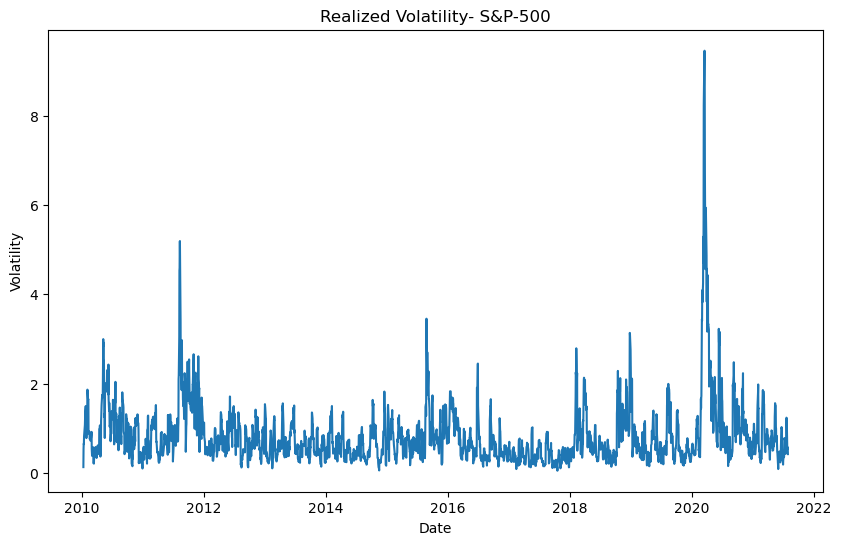

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')


ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

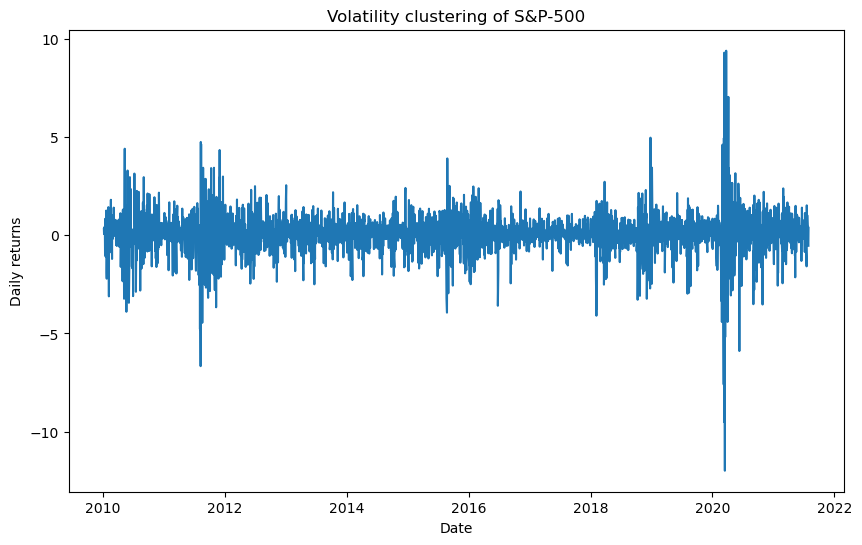

In [2]:
retv = ret.values

plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

In [3]:
n = 252
split_date = ret.iloc[-n:].index 

sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks


logliks = arch_likelihood(initial_parameters, retv)

def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                            method='Nelder-Mead',
                            options={'maxiter': 5000})
    params = opt_result.x 
    print('\nResults of Nelder-Mead minimization\n{}\n{}'
        .format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

params = opt_params(initial_parameters, retv)

def arch_apply(ret):
    omega = params[0]
    alpha = params[1]
    T = len(ret)
    sigma2_arch = np.zeros(T + 1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
    return sigma2_arch

sigma2_arch = arch_apply(ret)


Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1384.454903510854
             x: [ 7.015e-01  3.913e-01]
           nit: 30
          nfev: 58
 final_simplex: (array([[ 7.015e-01,  3.913e-01],
                       [ 7.016e-01,  3.913e-01],
                       [ 7.016e-01,  3.914e-01]]), array([ 1.384e+03,  1.384e+03,  1.384e+03]))

Resulting params = [0.70152949 0.39126701]
